# <font color='firebrick'><center>Report for Fragment Library Type</center> </font>

 This page contains the library fragment type information that is generated using a CGAT specific tool. This information can be required for a number of downstream processes such as running featurecounts for RNA-seq. We use the nomenclature, detailed in the salmon documentation. Accoding to the salmon documentation:
<br><br>
<i>  "There are numerous library preparation protocols for RNA-seq that result in sequencing reads with different characteristics. For example, reads can be single end (only one side of a fragment is recorded as a read) or paired-end (reads are generated from both ends of a fragment). Further, the sequencing reads themselves may be unstranded or strand-specific. Finally, paired-end protocols will have a specified relative orientation. To characterize the various different typs of sequencing libraries, we’ve created a miniature “language” that allows for the succinct description of the many different types of possible fragment libraries." </i> 
<br><br>
   The following table shows the <b> <font color='blue'> percent of reads </font> </b> mapping to each fragment library type. Visiting the salmon documentation will help you to determine the library type.
<br>



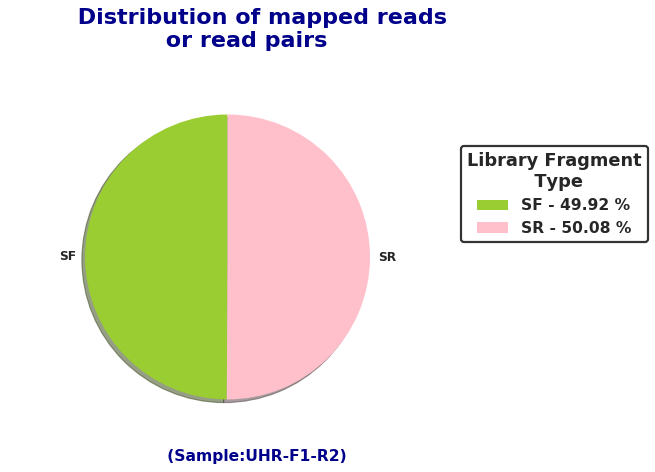

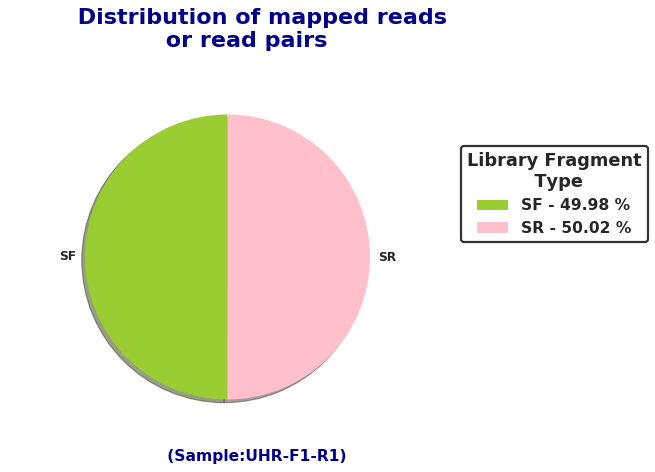

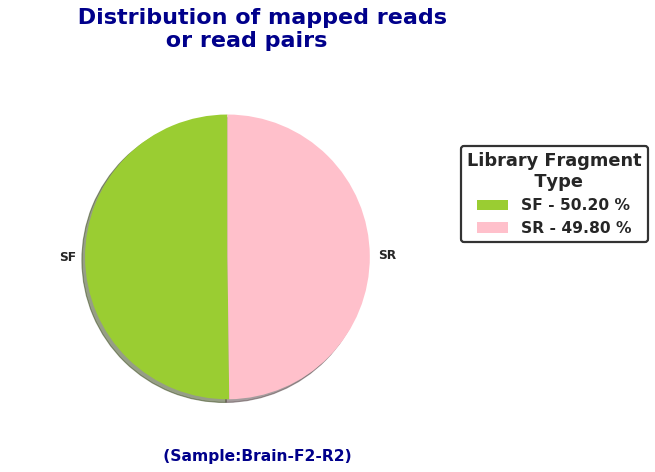

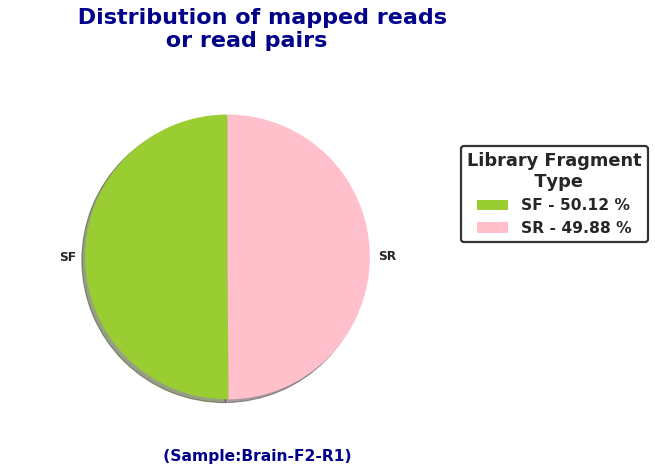

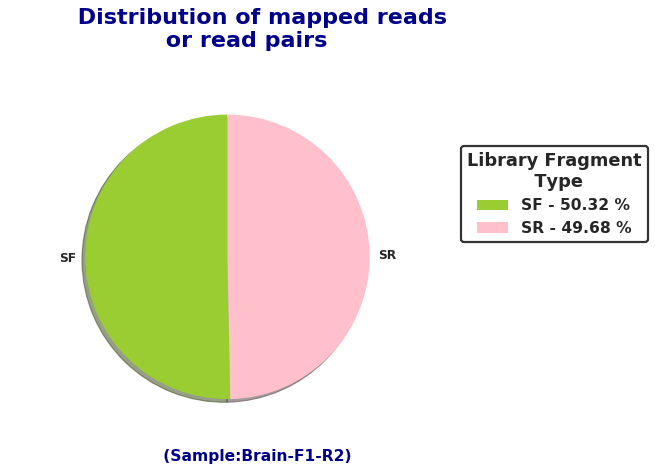

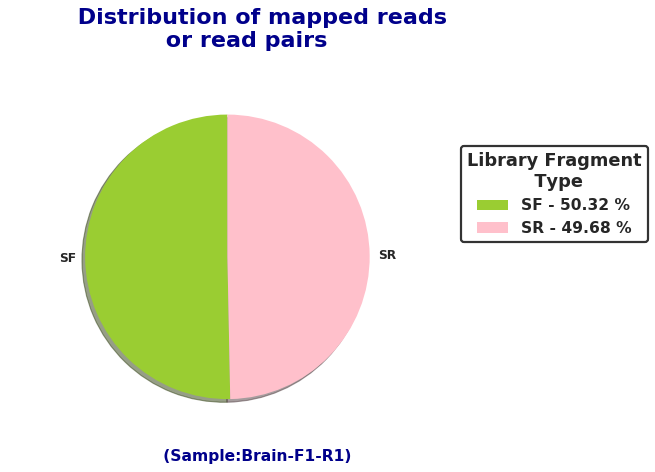

In [1]:
from IPython.display import display, Markdown
from IPython.display import HTML
import IPython.core.display as di
import csv
import numpy as np
import zlib
import CGAT.IOTools as IOTools
import itertools as ITL
import os
import string
import pandas as pd
import sqlite3
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages  # noqa: E402
#mpl.use('Agg')  # noqa: E402
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib import rc, font_manager
import CGAT.Experiment as E
import math
from random import shuffle
import matplotlib as mpl
import datetime
import seaborn as sns
import nbformat
%matplotlib inline  


##################################################
#Plot customization
#plt.ioff()
plt.style.use('seaborn-white')
#plt.style.use('ggplot')
title_font = {'size':'20','color':'darkblue', 'weight':'bold', 'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'size':'18', 'weight':'bold'}
#For summary page pdf
'''To add description page
plt.figure() 
plt.axis('off')
plt.text(0.5,0.5,"my title",ha='center',va='center')
pdf.savefig()
'''
#Panda data frame cutomization
pd.options.display.width = 80
pd.set_option('display.max_colwidth', -1)

colors_category = ['yellowgreen', 'pink', 'gold', 'lightskyblue', 
              'orchid','darkgoldenrod','skyblue','b', 'red', 
              'darkorange','grey','violet','magenta','cyan',
              'hotpink','mediumslateblue']
threshold = 5

def hover(hover_color="#ffff99"):
    return dict(selector="tr:hover",
                props=[("background-color", "%s" % hover_color)])

def getTables(dbname):
    '''
    Retrieves the names of all tables in the database.
    Groups tables into dictionaries by annotation
    '''
    dbh = sqlite3.connect(dbname)
    c = dbh.cursor()
    statement = "SELECT name FROM sqlite_master WHERE type='table'"
    c.execute(statement)
    tables = c.fetchall()
    print(tables)
    c.close()
    dbh.close()
    return 

def readDBTable(dbname, tablename):
    '''
    Reads the specified table from the specified database.
    Returns a list of tuples representing each row
    '''
    dbh = sqlite3.connect(dbname)
    c = dbh.cursor()
    statement = "SELECT * FROM %s" % tablename
    c.execute(statement)
    allresults = c.fetchall()
    c.close()
    dbh.close()
    return allresults

def getDBColumnNames(dbname, tablename):
    dbh = sqlite3.connect(dbname)
    res = pd.read_sql('SELECT * FROM %s' % tablename, dbh)
    dbh.close()
    return res.columns


def fancyPiePlot(list_to_plot,list_label,samplename,name,colors,s1,s2):

    fig=plt.figure(figsize=(6, 6), dpi=80)
    patches, autotexts = plt.pie(list_to_plot, colors=colors,labels=list_label,labeldistance=1.06,
                                 autopct=None,shadow=True, startangle=90,textprops={'weight': 'bold','fontsize':'16'})
    for i in range(0,len(autotexts)):
            autotexts[i].set_fontsize(11)
    #texts.set_fontsize(14)
    #for i, a in enumerate(autotexts):
       # a.set_text("{}".format((str(round(list_to_plot[i],2))+"%")))
    plt.axis('equal')
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(list_label, list_to_plot)]
    legend_properties = {'weight':'bold','size':'14'}
    leg = plt.legend(patches,labels,title="Library Fragment\n           Type",
                     prop=legend_properties,bbox_to_anchor=(s1,s2),frameon=True)
    leg.get_frame().set_edgecolor('k')
    leg.get_frame().set_linewidth(2)
    leg.get_title().set_fontsize(16)
    leg.get_title().set_fontweight('bold')
    plt.title(''.join(["         Distribution of ",name,"\n\n"]), **title_font)
    plt.xlabel(''.join(["\n\n           (Sample:",samplename,")"]),size=14,color='darkblue',weight='bold')
    plt.tight_layout()
    #plt.savefig(''.join([samplename,'_',"fragment_library_type",'.png']),bbox_inches='tight',pad_inches=0.6)
    plt.show()
    plt.close()
    print("\n\n\n\n")
    return fig 

def filterZeros(value,label,trackname):
    list_plot=[]
    list_label=[]
    for ii in range(0,len(value)):
        if(value[ii]>0):
            list_plot.append(value[ii])
            list_label.append(label[ii])
    fig = fancyPiePlot(list_plot,list_label,trackname,
                       "mapped reads\n     or read pairs",colors_category,1.6, 0.89)
    return fig


def displayTable(df,name):
    df1 = df.iloc[:,0:(df.shape[1]-1)]
    df1.index = [df['track']]
    #del df1.index.name
    # Display table
    styles = [
    hover(),
    dict(selector="th", props=[("font-size", "130%"),
                               ("text-align", "center"),
                              ]),                               
    dict(selector="td", props=[("font-size", "120%"),
                               ("text-align", "center"),
                              ]),
    dict(selector="caption", props=[("caption-side", "top"),
                                   ("text-align", "center"),
                                   ("font-size", "100%")])
    ]
    df1 = (df1.style.set_table_styles(styles).set_caption(name))
    display(df1)
    print("\n\n")
    

def fragmentLibraryStatsReport(dbname, tablename):
    trans = pd.DataFrame(readDBTable(dbname,tablename))
    trans.columns = getDBColumnNames(dbname,tablename)
    df=trans
    #pdf=PdfPages("fragment_library_type_stats_summary.pdf")
    label = list(df.columns[0:(df.shape[1]-1)])
    displayTable(df,"Fragment Library Type")
    for i in range(0,df.shape[0]):
        value = list(df.iloc[i][0:(df.shape[1]-1)])
        fig = filterZeros(value,label,df['track'][i])
        #pdf.savefig(fig,bbox_inches='tight',pad_inches=0.6)
    #pdf.close()
#getTables("csvdb")
fragmentLibraryStatsReport("../csvdb","strand_spec_strand")




